# Pythagoras via Matrix

In [2]:
%matplotlib inline
import math
import random
import operator
import warnings
import numpy as np

from geneticprogramming import Baseset
from geneticprogramming import Individual
from geneticprogramming import Population

warnings.filterwarnings("ignore")

## Training data 

* a number of random matrices (2D floating points) on a plane

In [3]:
SAMPLE_SIZE = 50
PLANE_SIZE = 20.0
RANDOMPOINTS = [PLANE_SIZE * np.random.random_sample((1, 2)) for _ in range(SAMPLE_SIZE)]

## Base functions

* _get_ a value at a location from a matrix
* an _ephemeral integer_ - either 0 or 1
* _addition_ and _subtraction_ of floats
* _square_ and _square root_ of floats

In [4]:
# setup the baseset
def getValue(ndarray, idx):
    """Return the indexed value from the 1x2 numpy array"""
    return ndarray[0][idx]

def if_then_else(input, output1, output2):
    if input:
        return output1
    else:
        return output2
    
def prog2(a, b):
    return a

def do(condition, value):
    return value

def let_t(float):
    return float

square = lambda x: x ** 2
sqrt = lambda x: math.sqrt(abs(x))

bset = Baseset()
bset.add_ephemeral('EM', lambda: np.random.rand(1, 2), np.ndarray)
bset.add_ephemeral('EF', lambda: random.random(), float)
bset.add_ephemeral('EI', lambda: random.randint(0, 1), int)

bset.add_primitive(getValue, [np.ndarray, int], float, name="get")
bset.add_primitive(operator.add, [float, float], float, name="add")
bset.add_primitive(operator.sub, [float, float], float, name="sub")
bset.add_primitive(square, [float], float, name="square")
bset.add_primitive(sqrt, [float], float, name="sqrt")

bset.add_primitive(operator.lt, [float, float], bool, name="lt")
bset.add_primitive(if_then_else, [bool, float, float], float, name="IF")
bset.add_primitive(prog2, [float, float], float, name="PROG2")
bset.add_primitive(do, [bool, float], float, name='DO')
bset.add_primitive(let_t, [float], float, name="LET_T")

bset.add_terminal(1.0, float, 'T')

## Individuals
* consume a matrix (a 1x2 array of floats - x and y coordinates)
* return a float (the distance from the origin)
* scored by accumulating the error when applying the Training data

In [5]:
Individual.INTYPES = [np.ndarray]
Individual.OUTTYPE = float

def evaluate(individual):
    """sum of application of all the random points"""
    program = individual.compile()
    score = 0
    try:
        for point in RANDOMPOINTS:
            program_distance = program(point)
            true_distance = math.hypot(point[0][0], point[0][1])
            score += abs(true_distance - program_distance)
    except (OverflowError, RuntimeWarning):
        pass
    if math.isnan(score) or score == 0:
        score = 100000

    # count the number of nodes and scale it. (Adds 1 whole unit to the score at 250 nodes).
    # nodes = sum([len(tree) for tree in individual.trees])
    # modifier = 1 + (-2 ** - (nodes / 250))

    # accumulate the number of nodes actually used during a run by calling the adfs in the rpb
    nodes = 0
    for node in individual.trees[-1]:
        if node.name[:1] != 'F':
            nodes += 1
        else:
            nodes += len(individual.trees[int(node.name[1])])
    modifier = 1 + (-2 ** - (nodes / 250))
    
    return score + modifier,

Individual.evaluate = evaluate

## Population Evolution

gen	avg    	std   	min    	max    
0  	936.774	1185.3	203.846	7121.46
1  	641.449	814.411	203.76 	6031.32
2  	534.723	823.879	203.76 	6031.32
3  	355.103	208.107	192.244	857.174
4  	247.054	33.3773	192.136	327.895
5  	260.03 	96.3322	192.096	762.019
6  	257.839	101.429	192.096	745.81 
7  	262.067	126.652	192.026	790.284
8  	223.53 	34.7894	192.026	315.116
9  	243.167	108.819	192.026	746.653
10 	235.667	108.874	118.842	746.653
11 	218.947	80.4913	118.842	746.814
12 	238.119	131.026	118.842	762.263
13 	203.995	41.5613	118.842	390.488
14 	201.781	54.1502	118.842	390.515
15 	188.956	47.3239	118.842	390.504
16 	187.713	78.1279	118.842	670.013
17 	180.643	48.5125	118.74 	301.892
18 	193.981	97.345 	118.74 	755.164
19 	204.504	124.984	118.74 	746.756


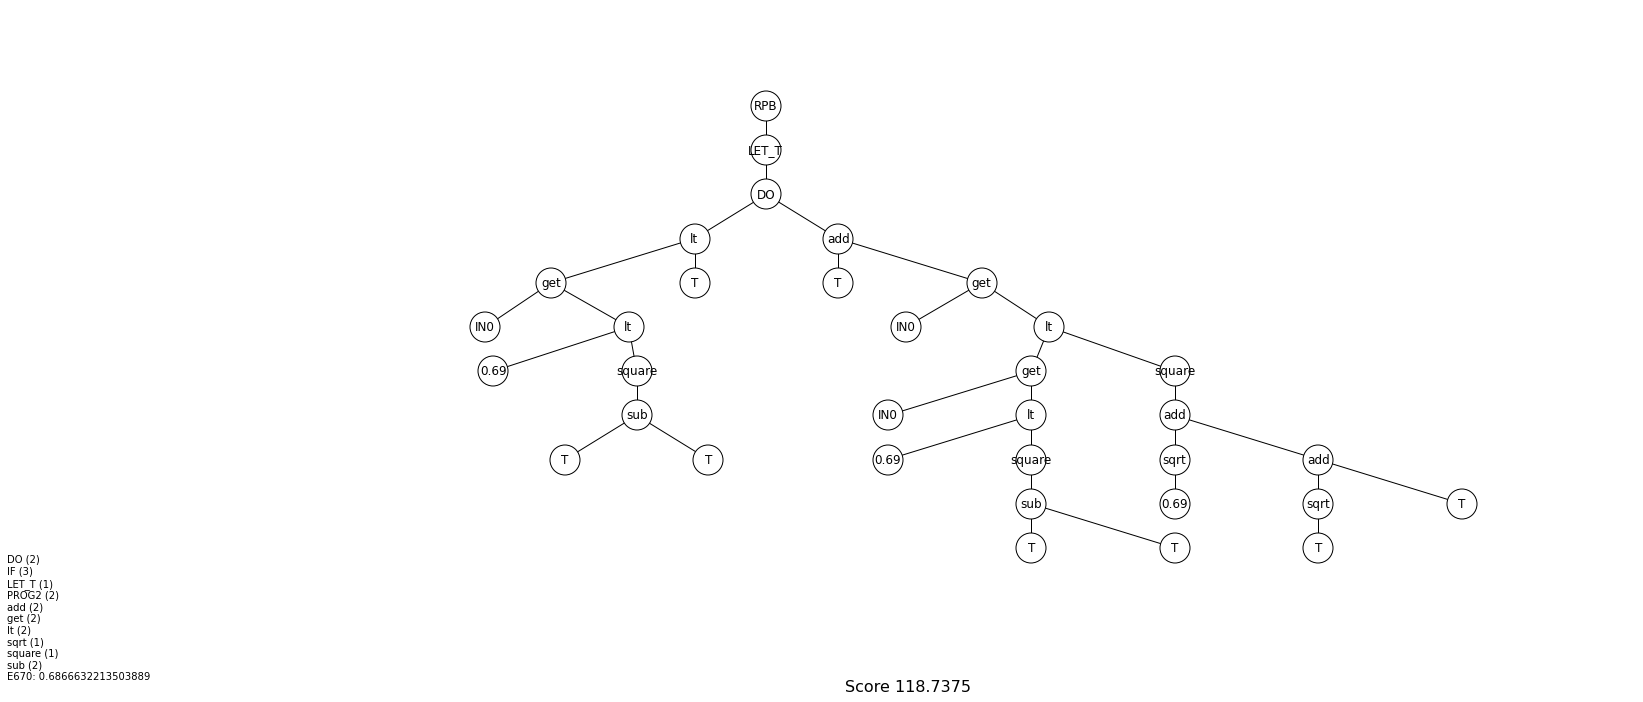

In [10]:
# run the evolution
Population.POPULATION_SIZE = 50  # Number of individuals in a generation
Population.MATE_MUTATE_CLONE = (70, 25, 5)  # ratio of individuals to mate, mutate, or clone
Population.CLONE_BEST = 1  # Number of best individuals to seed directly into offspring
Population.MAX_MATE_ATTEMPTS = 15 # Maximum number of paraents to try before error message

Individual.MAX_ADFS = 1  # The maximum number of ADFs to generate
Individual.ADF_NARGS = (1, 3)  # min, max number of input arguments to adfs
Individual.GROWTH_TERM_PB = 0.3  # Probability of terminal when growing:
Individual.GROWTH_MAX_INIT_DEPTH = 12  # Maximum depth of initial growth
Individual.GROWTH_MAX_MUT_DEPTH = 5  # Maximum depth of mutation growth
Individual.GROWTH_MAX_ATTEMPTS = 50  # maximum number of times to attempt to grow a complete adf before abandoning
Individual.GROWTH_MAX_SIGNATURES = 1000  # maximum number of signatures to try before ultimately giving up

NUMBER_OF_GENERATIONS = 20

population = Population(bset)
for gen in range(NUMBER_OF_GENERATIONS):
    population.evolve()
    if population[0].fitness.values[0] < 0.8:
        break

best = population[0]
best.draw()

In [7]:
print(best)


MAIN:add(sqrt(get(IN0, E170)), PROG2(add(sub(add(LET_T(PROG2(LET_T(get(IN0, lt(get(E168, E170), get(E168, E170)))), DO(lt(E169, T), E169))), E169), T), IF(lt(DO(lt(add(E169, add(PROG2(LET_T(T), LET_T(T)), E169)), square(T)), PROG2(LET_T(get(IN0, lt(get(E168, E170), get(E168, E170)))), DO(lt(E169, T), E169))), square(get(E168, lt(T, T)))), add(PROG2(sqrt(T), T), DO(lt(T, square(E169)), LET_T(E169))), E169)), add(T, E169)))
